## Configure PUDL
The `.pudl.yml` configuration file tells PUDL where to look for data. Uncomment the next cell and run it if you're on our 2i2c JupyterHub.

In [3]:
#!cp ~/shared/shared-pudl.yml ~/.pudl.yml

In [4]:
# import the necessary packages
%load_ext autoreload
%autoreload 2

import pandas as pd
import sqlalchemy as sa
import pudl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Connecting to the PUDL Databases

This notebook will walk you through several ways of pulling data out of the Public Utility Data Liberation (PUDL)
project databases and into [Pandas](https://pandas.pydata.org/) Dataframes for analysis and visualization.

This notebook assumes you have a development version of the [PUDL Python package](https://github.com/catalyst-cooperative/pudl) installed, and a complete PUDL database available locally, in the location expected by the Python package.

If you have any questions or feedback you can:
* [Create an issue](https://github.com/catalyst-cooperative/pudl-tutorials/issues) in the GitHub repo for our tutorials, or
* Contact the team at: pudl@catalyst.coop

## Direct SQLite Access
Much of the PUDL data is published as [SQLite database files](https://www.sqlite.org/index.html). These are relational databases generally intended for use by a single user at a time. If you're already familiar with databases and SQL in Python, you can access them just like you would any other. [Support for SQLite](https://docs.python.org/3/library/sqlite3.html) is built into the Python standard libraries, and the popular [SQLAlchemy](https://www.sqlalchemy.org) Python package also has extensive support for SQLite.  Here's one in-depth resource on using Python, SQLite and SQLAlchemy together: [Data Management with Python, SQLite, and SQLAlchemy](https://realpython.com/python-sqlite-sqlalchemy/)

For the rest of these tutorials, we're going to assume you want to get the data into Pandas as quickly as possible for interactive work.


## Database Normalization
The data in the PUDL database has been extensively deduplicated, [normalized](https://en.wikipedia.org/wiki/Database_normalization) and generally organized according to best practices of [tidy data](https://tidyr.tidyverse.org/articles/tidy-data.html) in order to ensure that it is internally self-consistent and free of errors. As a result, you'll often need to combine information from more than one table to make it readable or to get all the information you need for your analysis in one place. We've built some tools to do this automatically, which we'll get to below.

## Locate the PUDL DB file
Each SQLite database is stored within a single file. To access the data, you need to know where that file is. With the location of the file, you can create an [SQLAlchemy connection engine](https://docs.sqlalchemy.org/en/13/core/engines.html), which Pandas will use to read data out of the database. PUDL stores its data in a directory structure generally organized by file format. We store the paths to those directories and the SQLAlchemy database URLs in a Python dictionary that's usually called `pudl_settings`. Note that  a URL is just a path to a file that could be either local (on your computer) or remote (on someone else's computer). The following command will construct that `pudl_settings` dictionary based on some directory paths stored in the `.pudl.yml` file in your home directory. Printing out the dictionary contents you can see where PUDL will look for various resources.

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_settings

{'pudl_in': '/home/jovyan/shared',
 'data_dir': '/home/jovyan/shared/data',
 'settings_dir': '/home/jovyan/shared/settings',
 'pudl_out': '/home/jovyan/shared',
 'sqlite_dir': '/home/jovyan/shared/sqlite',
 'parquet_dir': '/home/jovyan/shared/parquet',
 'datapkg_dir': '/home/jovyan/shared/datapkg',
 'ferc1_db': 'sqlite:////home/jovyan/shared/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/jovyan/shared/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/jovyan/shared/sqlite/censusdp1tract.sqlite'}

## The SQLAlchemy Connection Engine
The `sqlalchemy.create_engine()` function takes a database URL and creates an Engine that knows how to interact with the database. It can do things like list out the names of all the tables in the database.

In [6]:
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
# see all the tables inside of the database
pudl_engine.table_names()

['assn_gen_eia_unit_epa',
 'assn_plant_id_eia_epa',
 'boiler_fuel_eia923',
 'boiler_generator_assn_eia860',
 'boilers_entity_eia',
 'coalmine_eia923',
 'energy_source_eia923',
 'ferc_accounts',
 'ferc_depreciation_lines',
 'fuel_ferc1',
 'fuel_receipts_costs_eia923',
 'fuel_type_aer_eia923',
 'fuel_type_eia923',
 'generation_eia923',
 'generation_fuel_eia923',
 'generators_eia860',
 'generators_entity_eia',
 'ownership_eia860',
 'plant_in_service_ferc1',
 'plant_unit_epa',
 'plants_eia',
 'plants_eia860',
 'plants_entity_eia',
 'plants_ferc1',
 'plants_hydro_ferc1',
 'plants_pudl',
 'plants_pumped_storage_ferc1',
 'plants_small_ferc1',
 'plants_steam_ferc1',
 'prime_movers_eia923',
 'purchased_power_ferc1',
 'transport_modes_eia923',
 'utilities_eia',
 'utilities_eia860',
 'utilities_entity_eia',
 'utilities_ferc1',
 'utilities_pudl',
 'utility_plant_assn']

# Reading data with `pandas.read_sql()`
The [pandas.read_sql()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) method is the simplest way to pull data from an SQL database into a dataframe. You can give it an SQL statement to execute, or just the name of a table to read in its entirety.

## Read a whole table
Reading an entire table all at once is easy. It isn't very memory efficient but there's less than 1 GB of data in the PUDL database, so in most cases this is a fine option. Once you've had a chance to poke around at the whole table a bit, you can select the data that's actually of interest out of it for your analysis or visualization.

You can also explore the contents of the database interactively online at https://data.catalyst.coop if you want to familiarize yourself with its contents in a more graphical way first.

In [58]:
utilities_eia860 = pd.read_sql('utilities_eia860', pudl_engine)

In [59]:
utilities_eia860.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94895 entries, 0 to 94894
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  94895 non-null  int64         
 1   utility_id_eia                      94895 non-null  int64         
 2   report_date                         94895 non-null  datetime64[ns]
 3   street_address                      62509 non-null  object        
 4   city                                81986 non-null  object        
 5   state                               81965 non-null  object        
 6   zip_code                            81786 non-null  object        
 7   plants_reported_owner               26252 non-null  object        
 8   plants_reported_operator            10925 non-null  object        
 9   plants_reported_asset_manager       5799 non-null   object        
 10  plants_reported_other_

In [60]:
utilities_eia860_tampa = utilities_eia860.loc[utilities_eia860.zip_code.isin(["33572",	"33503","33596","33510","33511","33618","33624","33558","33625","33527",
                   "33614",	"33547","33534","33556","33559","33548","33549","33619","33563","33565",
                   "33566",	"33567","33569","33578","33579","33570","33584","33573","33602","33603",
                   "33604",	"33605","33606","33607","33609","33610","33611","33612","33620","33621",
                   "33616",	"33629","33647","33637","33617","33592","33615","33634","33635","33613",
                   "33594",	"33626","33598"])]

In [63]:
utilities_eia860_tampa.shape
display(utilities_eia860_tampa)

,id,utility_id_eia,report_date,street_address,city,state,zip_code,plants_reported_owner,plants_reported_operator,plants_reported_asset_manager,...,contact_firstname,contact_lastname,contact_title,contact_firstname_2,contact_lastname_2,contact_title_2,phone_extension_1,phone_extension_2,phone_number_1,phone_number_2
9846,9847,24900,2019-01-01,660 East County Line Road,Plant City,FL,33565,True,None,None,...,None,None,None,None,None,None,None,None,None,None
9920,9921,21554,2019-01-01,16313 North Dale Mabry Highway,Tampa,FL,33618,True,True,None,...,None,None,None,None,None,None,None,None,None,None
10107,10108,18483,2019-01-01,2700 Maritime Blvd,Tampa,FL,33605,True,None,None,...,None,None,None,None,None,None,None,None,None,None
10110,10111,18454,2019-01-01,702 North Franklin Street,Tampa,FL,33602,True,None,None,...,None,None,None,None,None,None,None,None,None,None
14853,14854,24900,2018-01-01,660 East County Line Road,Plant City,FL,33565,True,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94136,94137,2879,2004-01-01,Suite 1200,Tampa,FL,33607,None,None,None,...,Kent,Locker,Plant Engineer,JD,Sellers,Plant Manager,None,None,256-301-6510,256-234-8918
94139,94140,2875,2004-01-01,Suite 1200,Tampa,FL,33607,None,None,None,...,Benjamin,Borsch,"Manager, SH&E",Craig,Chancellor,Director-NG Regulatory,None,None,813-637-7305,713-335-4136
94142,94143,2872,2004-01-01,Suite 120,Tampa,FL,33607,None,None,None,...,Steve,Wunderlich,Plant Engineer,Bob,Callery,General Manager,None,None,863-965-1561,863-551-4665
94290,94291,2267,2004-01-01,2701 North Rocky Point Dr,Tampa,FL,33607,None,None,None,...,Paul,Garrett,Plant Manager,Donald,Walters,Regional VP Operations,221,None,864-206-0450,617-557-5394


In [65]:
# utilities_eia860_tampa
utility_ids_tampa = list(utilities_eia860_tampa.utility_id_eia.unique())
print(utility_ids_tampa)

[24900, 21554, 18483, 18454, 17887, 1005, 2929, 54796, 55776, 55137, 49934, 49933, 26644, 24106, 18437, 8329, 2875, 29122, 2879, 3102, 2267, 23142, 2872]


In [10]:
generation_df = pd.read_sql("generators_eia860", pudl_engine)
generation_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404158 entries, 0 to 404157
Data columns (total 66 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   id                                     404158 non-null  int64         
 1   plant_id_eia                           404158 non-null  int64         
 2   generator_id                           404158 non-null  object        
 3   report_date                            404158 non-null  datetime64[ns]
 4   operational_status_code                398383 non-null  object        
 5   operational_status                     403777 non-null  object        
 6   ownership_code                         373737 non-null  object        
 7   owned_by_non_utility                   52772 non-null   object        
 8   utility_id_eia                         402004 non-null  float64       
 9   capacity_mw                            403756 no

In [11]:
generator_table_sample = generation_df.sort_values(by='generator_id').head(1000)

In [7]:
generator_table_sample.to_csv('generator_table_sample.csv')

In [7]:
generation_eia923_df = pd.read_sql("generation_eia923", pudl_engine)

In [8]:
generation_eia923_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479352 entries, 0 to 479351
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  479352 non-null  int64         
 1   plant_id_eia        479352 non-null  int64         
 2   generator_id        479352 non-null  object        
 3   report_date         479352 non-null  datetime64[ns]
 4   net_generation_mwh  454504 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 41.8 MB


## EDA

In [12]:
generator_table_sun = generation_df.loc[generation_df.energy_source_code_1 == 'SUN']

In [13]:
generator_table_sun.shape

(30795, 66)

In [14]:
generator_table_sun.operational_status.value_counts()

existing    21935
proposed     6781
retired      2079
Name: operational_status, dtype: int64

In [15]:
generator_table_sun.head()

,id,plant_id_eia,generator_id,report_date,operational_status_code,operational_status,ownership_code,owned_by_non_utility,utility_id_eia,capacity_mw,...,switch_oil_gas,nameplate_power_factor,minimum_load_mw,uprate_derate_during_year,uprate_derate_completed_date,current_planned_operating_date,summer_estimated_capability_mw,winter_estimated_capability_mw,retirement_date,data_source
0,1,64272,AEC1,2020-01-01,"(U) Under construction, less than or equal to ...",proposed,None,None,63862.0,100.0,...,None,NaN,NaN,None,NaT,2021-12-01,NaN,NaN,NaT,eia860m
1,2,64270,COLT1,2020-01-01,"(V) Under construction, more than 50 percent c...",proposed,None,None,62915.0,2.6,...,None,NaN,NaN,None,NaT,2021-07-01,NaN,NaN,NaT,eia860m
2,3,64266,264,2020-01-01,"(V) Under construction, more than 50 percent c...",proposed,None,None,60025.0,1.6,...,None,NaN,NaN,None,NaT,2021-01-01,NaN,NaN,NaT,eia860m
3,4,64264,298,2020-01-01,"(V) Under construction, more than 50 percent c...",proposed,None,None,60025.0,3.0,...,None,NaN,NaN,None,NaT,2021-01-01,NaN,NaN,NaT,eia860m
4,5,64263,364,2020-01-01,"(V) Under construction, more than 50 percent c...",proposed,None,None,60025.0,1.0,...,None,NaN,NaN,None,NaT,2021-01-01,NaN,NaN,NaT,eia860m


In [30]:
generation_df_existing= generation_df.loc[generation_df.operational_status =='existing']

In [50]:
generation_df_existing_sub = generation_df_existing[['utility_id_eia','id','plant_id_eia','generator_id','report_date','energy_source_code_1','operational_status','capacity_mw']]

In [51]:
generation_df_existing_sub.utility_id_eia.value_counts()

55938.0    5626
18642.0    4883
54842.0    3442
2518.0     3185
5914.0     2827
           ... 
22609.0       1
28086.0       1
60568.0       1
62846.0       1
54795.0       1
Name: utility_id_eia, Length: 6524, dtype: int64

In [67]:
generation_df_existing_sub['plant_generator_id']= generation_df_existing_sub.plant_id_eia.astype('str') + '_' + generation_df_existing_sub.generator_id

/tmp/ipykernel_66/3762398890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation_df_existing_sub['plant_generator_id']= generation_df_existing_sub.plant_id_eia.astype('str') + '_' + generation_df_existing_sub.generator_id


In [68]:
generation_df_existing_sub['plant_generator_id'].value_counts()

1263_4         17
3612_3         17
50696_GEN1     17
1287_8         17
7527_CCCT      17
               ..
7793_2          1
63244_SYDN      1
55099_8         1
63794_ST001     1
54536_201       1
Name: plant_generator_id, Length: 28564, dtype: int64

In [69]:
plant_ids = list(generation_df_existing_sub.plant_id_eia.unique())
print(plant_ids)

[64242, 64232, 64231, 64227, 64226, 64200, 64198, 64195, 64194, 64193, 64192, 64190, 64176, 64175, 64173, 64158, 64157, 64143, 64142, 64141, 64137, 64123, 64121, 64120, 64119, 64118, 64117, 64116, 64115, 64114, 64113, 64112, 64111, 64110, 64109, 64108, 64107, 64102, 64101, 64098, 64096, 64093, 64092, 64091, 64090, 64087, 64085, 64084, 64078, 64072, 64060, 64055, 64046, 64045, 64044, 64042, 64041, 64034, 64033, 64031, 64030, 64025, 64023, 64021, 64020, 64018, 64017, 64014, 64011, 64007, 64004, 64002, 63997, 63994, 63993, 63986, 63977, 63970, 63969, 63965, 63957, 63953, 63950, 63945, 63942, 63937, 63935, 63934, 63928, 63927, 63926, 63925, 63924, 63923, 63922, 63921, 63920, 63919, 63918, 63908, 63904, 63903, 63893, 63889, 63888, 63869, 63860, 63858, 63857, 63856, 63855, 63854, 63853, 63852, 63844, 63839, 63837, 63836, 63835, 63834, 63833, 63832, 63831, 63829, 63826, 63825, 63821, 63820, 63819, 63817, 63814, 63804, 63803, 63800, 63796, 63795, 63794, 63791, 63790, 63786, 63781, 63780, 63779

In [70]:
generation_eia923_df_plants_sub = generation_eia923_df.loc[generation_eia923_df.plant_id_eia.isin(plant_ids)]
generation_eia923_df_plants_sub.shape

(479352, 5)

In [72]:
generation_eia923_df_plants_sub.head(50)

,id,plant_id_eia,generator_id,report_date,net_generation_mwh
0,1,3,1,2009-01-01,39699.0
1,2,3,1,2009-02-01,5594.0
2,3,3,1,2009-03-01,13015.0
3,4,3,1,2009-04-01,15858.0
4,5,3,1,2009-05-01,68232.0
5,6,3,1,2009-06-01,12428.0
6,7,3,1,2009-07-01,0.0
7,8,3,1,2009-08-01,-907.0
8,9,3,1,2009-09-01,-856.0
9,10,3,1,2009-10-01,6058.0


In [73]:
generation_eia923_df_plants_sub['plant_generator_id']= generation_eia923_df_plants_sub.plant_id_eia.astype('str') + '_' + generation_eia923_df_plants_sub.generator_id
print(generation_eia923_df_plants_sub['plant_generator_id'].value_counts())

10025_43TG    132
6085_18       132
3407_2        132
8069_2        132
55375_ST1     132
             ... 
2003_6         12
62873_7475     12
10476_GEN4     12
1960_1         12
58176_ST#3     12
Name: plant_generator_id, Length: 5079, dtype: int64


In [74]:
print(generation_df_existing_sub.columns)
print(generation_eia923_df_plants_sub.columns)

Index(['utility_id_eia', 'id', 'plant_id_eia', 'generator_id', 'report_date',
       'energy_source_code_1', 'operational_status', 'capacity_mw',
       'plant_generator_id'],
      dtype='object')
Index(['id', 'plant_id_eia', 'generator_id', 'report_date',
       'net_generation_mwh', 'plant_generator_id'],
      dtype='object')


In [75]:
generation_df_existing_sub_2 = generation_df_existing_sub.sort_values(by = ['plant_generator_id','report_date']).drop_duplicates('plant_generator_id', keep = 'last')
generation_df_existing_sub_2.shape

(28564, 9)

In [76]:
generation_eia923_info = generation_eia923_df_plants_sub.merge(generation_df_existing_sub_2, how = 'left', left_on = 'plant_generator_id', right_on = 'plant_generator_id')

In [77]:
generation_eia923_df_plants_sub.shape

(479352, 6)

In [78]:
print(generation_eia923_info.shape)
generation_eia923_info.head()

(479352, 14)


,id_x,plant_id_eia_x,generator_id_x,report_date_x,net_generation_mwh,plant_generator_id,utility_id_eia,id_y,plant_id_eia_y,generator_id_y,report_date_y,energy_source_code_1,operational_status,capacity_mw
0,1,3,1,2009-01-01,39699.0,3_1,195.0,29971.0,3.0,1,2020-01-01,NG,existing,153.1
1,2,3,1,2009-02-01,5594.0,3_1,195.0,29971.0,3.0,1,2020-01-01,NG,existing,153.1
2,3,3,1,2009-03-01,13015.0,3_1,195.0,29971.0,3.0,1,2020-01-01,NG,existing,153.1
3,4,3,1,2009-04-01,15858.0,3_1,195.0,29971.0,3.0,1,2020-01-01,NG,existing,153.1
4,5,3,1,2009-05-01,68232.0,3_1,195.0,29971.0,3.0,1,2020-01-01,NG,existing,153.1


In [79]:
generation_eia923_2 = generation_eia923_info.loc[~generation_eia923_info.id_y.isnull()]
print(generation_eia923_2.shape)

(478632, 14)


In [80]:
generation_eia923_3 = generation_eia923_2.loc[generation_eia923_2.utility_id_eia.isin(utility_ids_tampa)]

In [82]:
generation_eia923_3.shape
display(generation_eia923_3)

,id_x,plant_id_eia_x,generator_id_x,report_date_x,net_generation_mwh,plant_generator_id,utility_id_eia,id_y,plant_id_eia_y,generator_id_y,report_date_y,energy_source_code_1,operational_status,capacity_mw
780,781,136,1,2009-01-01,225059.0,136_1,21554.0,29620.0,136.0,1,2020-01-01,BIT,existing,735.9
781,782,136,1,2009-02-01,407871.0,136_1,21554.0,29620.0,136.0,1,2020-01-01,BIT,existing,735.9
782,783,136,1,2009-03-01,320254.0,136_1,21554.0,29620.0,136.0,1,2020-01-01,BIT,existing,735.9
783,784,136,1,2009-04-01,299048.0,136_1,21554.0,29620.0,136.0,1,2020-01-01,BIT,existing,735.9
784,785,136,1,2009-05-01,232839.0,136_1,21554.0,29620.0,136.0,1,2020-01-01,BIT,existing,735.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469123,469124,55293,STG1,2019-08-01,107897.0,55293_STG1,29122.0,12542.0,55293.0,STG1,2020-01-01,NG,existing,270.0
469124,469125,55293,STG1,2019-09-01,116572.0,55293_STG1,29122.0,12542.0,55293.0,STG1,2020-01-01,NG,existing,270.0
469125,469126,55293,STG1,2019-10-01,85956.0,55293_STG1,29122.0,12542.0,55293.0,STG1,2020-01-01,NG,existing,270.0
469126,469127,55293,STG1,2019-11-01,132810.0,55293_STG1,29122.0,12542.0,55293.0,STG1,2020-01-01,NG,existing,270.0


In [83]:
generation_eia923_3.to_csv('tampa_generation_eia923.csv')

In [48]:
generation_eia923_2_group = generation_eia923_2.groupby('report_date_x').sum()
generation_eia923_2_group_reset = generation_eia923_2_group.reset_index()

In [49]:
generation_eia923_2_group_reset.columns

Index(['report_date_x', 'id_x', 'plant_id_eia_x', 'net_generation_mwh', 'id_y',
       'plant_id_eia_y', 'capacity_mw'],
      dtype='object')

In [59]:
df.columns

Index(['report_date_x', 'id_x', 'plant_id_eia_x', 'net_generation_mwh', 'id_y',
       'plant_id_eia_y', 'capacity_mw'],
      dtype='object')

In [26]:
generator_table_sun_existing_sub.report_date.value_counts()

2020-01-01    4361
2019-01-01    3967
2018-01-01    3388
2017-01-01    2839
2016-01-01    2256
2015-01-01    1652
2014-01-01    1249
2013-01-01     874
2012-01-01     553
2011-01-01     326
2010-01-01     180
2009-01-01     110
2008-01-01      89
2007-01-01      38
2006-01-01      18
2005-01-01      18
2004-01-01      17
Name: report_date, dtype: int64

In [24]:
generator_table_sun_existing_sub_group = generator_table_sun_existing_sub.groupby('report_date').sum()

In [25]:
generator_table_sun_existing_sub_group.shape

(17, 3)

In [48]:
# generator_table_sun_existing_sub_group

In [30]:
df = generator_table_sun_existing_sub_group.reset_index()

In [49]:
# generator_table_sun_plant_57538 = generator_table_sun.loc[generator_table_sun.plant_id_eia==57538]

In [50]:
# generator_table_sun_plant_57538.shape

In [51]:
# generator_table_sun_plant_57538.head()

In [15]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

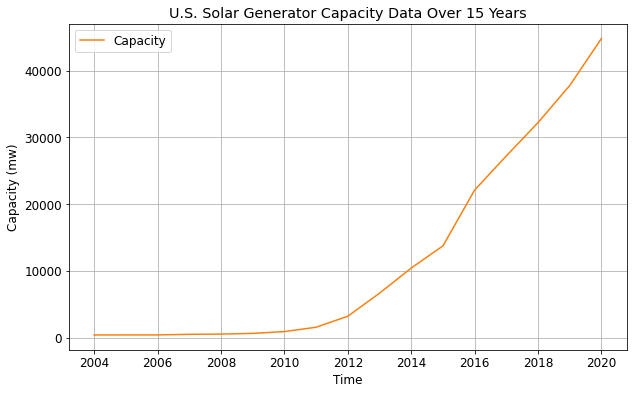

In [33]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df.report_date, df.capacity_mw, color='tab:orange', label='Capacity')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Capacity (mw)')
ax.set_title('U.S. Solar Generator Capacity Data Over 15 Years')
ax.grid(True)
ax.legend(loc='upper left');

In [56]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

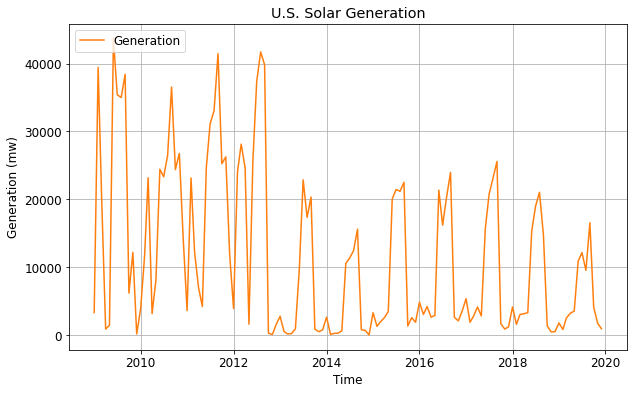

In [60]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df.report_date_x, df.net_generation_mwh, color='tab:orange', label='Generation')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Generation (mw)')
ax.set_title('U.S. Solar Power Generation (mw)')
ax.grid(True)
ax.legend(loc='upper left');

## Select specific data using SQL
If you're familiar with SQL, and you already know what subset of the data you want to pull out of the database, you can give Pandas an SQL statement directly, along with the `pudl_engine`, and it will put the results of the SQL statement into a dataframe for you.

For example, the following statement sums the nameplate capacities of generators by power plant, for every generator that reported a capacity in the EIA 860 in 2019, excluding those in Alaska and Hawaii. It sorts the results by capacity with the biggest plants first, and only returns the biggest 1000 plants.

[Compare with the results from our online database](https://data.catalyst.coop/pudl?sql=select%0D%0A++plants.plant_id_eia%2C%0D%0A++plants.plant_name_eia%2C%0D%0A++SUM%28gens.capacity_mw%29+as+plant_capacity_mw%2C%0D%0A++latitude%2C%0D%0A++longitude%0D%0Afrom%0D%0A++generators_eia860+as+gens%0D%0Ajoin%0D%0A++plants_entity_eia+as+plants%0D%0Awhere%0D%0A++plants.plant_id_eia+%3D+gens.plant_id_eia%0D%0A++and+gens.report_date+%3D+%222019-01-01%22%0D%0A++and+plants.state+not+in+%28%22HI%22%2C+%22AK%22%29%0D%0Agroup+by%0D%0A++plants.plant_id_eia%0D%0Aorder+by%0D%0A++plant_capacity_mw+desc).

This method is much faster and less memory intensive than reading whole tables, but it requires familiarity with SQL and the structure of the database. If you have a solid state disk and plenty of RAM, reading whole tables into memory is generally plenty fast, and shouldn't run into memory constraints.

In [7]:
example_sql = """
SELECT
  plants.plant_id_eia,
  plants.plant_name_eia,
  SUM(gens.capacity_mw) AS plant_capacity_mw,
  latitude,
  longitude
FROM
  generators_eia860 AS gens
JOIN
  plants_entity_eia AS plants
WHERE
  plants.plant_id_eia = gens.plant_id_eia
  AND gens.report_date = "2019-01-01"
  AND plants.state not in ("HI", "AK")
GROUP BY
  plants.plant_id_eia
ORDER BY
  plant_capacity_mw DESC
LIMIT 1000;
"""
big_plants_df = pd.read_sql(example_sql, pudl_engine)
big_plants_df

,plant_id_eia,plant_name_eia,plant_capacity_mw,latitude,longitude
0,6163,Grand Coulee,6809.0,47.957511,-118.977323
1,6043,Martin,6071.5,27.053600,-80.562800
2,628,Crystal River,5303.7,28.965600,-82.697700
3,649,Vogtle,4630.0,33.142700,-81.762500
4,56407,West County Energy Center,4263.0,26.698600,-80.374700
...,...,...,...,...,...
995,389,El Centro Hybrid,438.3,32.802222,-115.540000
996,118,Saguaro,435.5,32.551700,-111.300000
997,63113,Southern Bighorn Solar Hybrid,435.0,36.304793,-114.472803
998,56163,KUCC,434.5,40.711900,-112.122500


## The SQLAlchemy expression language
SQLAlchemy provides a Python API for building complex SQL queries, and `pandas.read_sql()` can accept these query objects in place of the SQL statement written out by hand as above. [See the SQLAlchemy documentation for more details](https://docs.sqlalchemy.org/en/13/core/tutorial.html).

# Read tables using the PUDL output layer
Early on in the development of the PUDL database, we found that we were frequently joining the same tables together, and calculating the same derived values in Pandas during our interactive analyses. So we wrote some code to do that work automatically and uniformly. We call this the PUDL Output Layer. It brings in fields like plant and utility names from their home tables, so you have more than just the numeric ID to go by, caches dataframes internally for re-use, and can do some time series aggregation.

These outputs are "denormalized" -- meaning that data will be duplicated in different output tables, and they will contain derived values that don't represent unique information. This structure isn't good inside a database, but it's great for interactive use.

The 2nd notebook in this tutorial is all about the `PudlTabl` objects, which we usually name `pudl_out`, but here is a quick preview.

If you want to access de-normalized tables, we've built an access methodology that saves access methods for most denormalized tables in PUDL and analysis build ontop of PUDL tables. There is a whole other notebook that covers the output tables so if you want more info on that.

## Create a PudlTabl output object
The tabular output object needs to know what PUDL database it's connecting to (via the `pudl_engine` argument), and optionally, what time frequency it should aggregate tables on.

In [9]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

## Construct denormalized dataframes
The `PudlTabl` object, called `pudl_out` here, has a bunch of methods corresponding to individual tables within the database. They typically use abbreviated names. Hitting `Tab` will show you a preview the available methods.

The `gen_eia923()` method corresponds to the `generation_eia923` table in the database, which details the monthly net generation from each generator reporting on the EIA Form 923.

Note: if you re-run the cell, it will complete almost instantly, because the dataframe has been cached inside the `pudl_out` object for later use.

In [10]:
%%time
gen_eia923 = pudl_out.gen_eia923()
gen_eia923.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476052 entries, 0 to 476051
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   report_date         476052 non-null  object 
 1   plant_id_eia        476052 non-null  Int64  
 2   plant_id_pudl       476052 non-null  Int64  
 3   plant_name_eia      476052 non-null  object 
 4   utility_id_eia      476052 non-null  Int64  
 5   utility_id_pudl     476052 non-null  Int64  
 6   utility_name_eia    476052 non-null  object 
 7   generator_id        476052 non-null  object 
 8   net_generation_mwh  451368 non-null  float64
dtypes: Int64(4), float64(1), object(4)
memory usage: 38.1+ MB
CPU times: user 8.67 s, sys: 17.4 ms, total: 8.69 s
Wall time: 11.9 s


In [10]:
gen_eia923.sample(10)

,report_date,plant_id_eia,plant_id_pudl,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,generator_id,net_generation_mwh
22747,2009-08-01,10398,3229,ISG Cleveland Works,9454,518,ISG Cleveland Inc,GENB,1152.0
192993,2014-10-01,2322,116,Clark (NVE),13407,204,Nevada Power Co,9,-195.0
234451,2015-08-01,7,206,Gadsden,195,18,Alabama Power Co,2,-367.0
418218,2018-07-01,55221,4455,Wrightsville Power Facility,807,529,Arkansas Electric Coop Corp,G9,14858.0
298941,2016-10-01,3804,493,Possum Point,19876,349,Dominion Virginia Power,6A,306520.0
340703,2017-12-01,1843,1892,Shiras,11701,1092,Marquette City of,3,25921.0
64125,2010-10-01,54338,4063,Rio Grande Valley Sugar Growers,16098,3006,"Rio Grande Valley Sugar Growers, Inc.",GENA,5.0
360840,2017-01-01,50498,3687,Capitol District Energy Center,2956,5579,Capital District Energy Center,GTG,182.0
401214,2018-07-01,10091,3104,Total Energy Facilities,11217,2301,Los Angeles County Sanitation,GEN4,2540.0
212737,2014-02-01,50359,3612,Sloss Industries Corp,17330,3694,"ERP Compliant Coke, LLC",9,0.0


## Compare with the normalized DB table
The denormalized version of the table above includes fields like `utility_name_eia923` and `plant_name_eia923` and `plant_id_pudl` which are all useful, but aren't fundamentally part of this table -- they can all be looked up in other tables based on the value of `plant_id_eia` found in the original `generation_eia923` table, so storing them in this table would mean duplicating data.  You can see what the original table looks like below.

Note also that since we're going back to the database directly rather than accessing the cached dataframe within the `pudl_out` object, this query will take a few seconds to run, just like the first time we read the table using `pudl_out` above.

In [11]:
%%time
gen_eia923_normalized = pd.read_sql("generation_eia923", pudl_engine)
gen_eia923_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479352 entries, 0 to 479351
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  479352 non-null  int64         
 1   plant_id_eia        479352 non-null  int64         
 2   generator_id        479352 non-null  object        
 3   report_date         479352 non-null  datetime64[ns]
 4   net_generation_mwh  454504 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 18.3+ MB
CPU times: user 2.43 s, sys: 51.3 ms, total: 2.48 s
Wall time: 3.56 s


In [12]:
gen_eia923_normalized.sample(10)

,id,plant_id_eia,generator_id,report_date,net_generation_mwh
119358,119359,2876,2,2012-07-01,95685.0
383026,383027,58159,CGT3,2017-11-01,3099.0
52282,52283,4048,3,2010-11-01,0.0
291771,291772,874,6,2016-04-01,0.0
419922,419923,55132,GTG1,2018-07-01,91226.0
81025,81026,2324,4,2011-02-01,77498.0
91005,91006,7710,ST3,2011-10-01,117028.0
314881,314882,50305,GEN9,2016-02-01,3666.0
9736,9737,2067,2,2009-05-01,NaN
477943,477944,58557,GT2,2019-08-01,90501.0


# FERC Form 1: Here Be Dragons
You might have noticed up above that there were actually two SQLite database URLs in the `pudl_settings` object... One for PUDL, and another for FERC Form 1.

In [13]:
pudl_settings

{'pudl_in': '/home/zane/code/catalyst/pudl-work',
 'data_dir': '/home/zane/code/catalyst/pudl-work/data',
 'settings_dir': '/home/zane/code/catalyst/pudl-work/settings',
 'pudl_out': '/home/zane/code/catalyst/pudl-work',
 'sqlite_dir': '/home/zane/code/catalyst/pudl-work/sqlite',
 'parquet_dir': '/home/zane/code/catalyst/pudl-work/parquet',
 'datapkg_dir': '/home/zane/code/catalyst/pudl-work/datapkg',
 'notebook_dir': '/home/zane/code/catalyst/pudl-work/notebook',
 'ferc1_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/zane/code/catalyst/pudl-work/sqlite/pudl.sqlite'}

## FERC Form 1: Direct vs. PUDL
The PUDL database contains a tiny fraction of the data available in the original FERC Form 1 -- we have only taken the time to clean a handful of the FERC tables. The original FERC Form 1 data is often very messy and poorly organized. However, if you need to access one of the original 113 tables that we haven't integrated yet, they're all available, going back to 1994. The original tables are only accessible via direct queries (either using SQL or pulling whole tables) from the original FERC Form 1 database, so you'll have to use the `pandas.read_sql()` methods outlined above.

If there are particular tables within the FERC Form 1 that you think are important to get cleaned up, let us know so we can prioritize them going forward!

In [14]:
ferc1_engine = sa.create_engine(pudl_settings["ferc1_db"])
# see all the tables inside of the database
ferc1_engine.table_names()

['f1_106_2009',
 'f1_106a_2009',
 'f1_106b_2009',
 'f1_208_elc_dep',
 'f1_231_trn_stdycst',
 'f1_324_elc_expns',
 'f1_325_elc_cust',
 'f1_331_transiso',
 'f1_338_dep_depl',
 'f1_397_isorto_stl',
 'f1_398_ancl_ps',
 'f1_399_mth_peak',
 'f1_400_sys_peak',
 'f1_400a_iso_peak',
 'f1_429_trans_aff',
 'f1_acb_epda',
 'f1_accumdepr_prvsn',
 'f1_accumdfrrdtaxcr',
 'f1_adit_190_detail',
 'f1_adit_190_notes',
 'f1_adit_amrt_prop',
 'f1_adit_other',
 'f1_adit_other_prop',
 'f1_allowances',
 'f1_allowances_nox',
 'f1_audit_log',
 'f1_bal_sheet_cr',
 'f1_capital_stock',
 'f1_cash_flow',
 'f1_cmmn_utlty_p_e',
 'f1_cmpinc_hedge',
 'f1_cmpinc_hedge_a',
 'f1_co_directors',
 'f1_codes_val',
 'f1_col_lit_tbl',
 'f1_comp_balance_db',
 'f1_construction',
 'f1_control_respdnt',
 'f1_cptl_stk_expns',
 'f1_csscslc_pcsircs',
 'f1_dacs_epda',
 'f1_dscnt_cptl_stk',
 'f1_edcfu_epda',
 'f1_elc_op_mnt_expn',
 'f1_elc_oper_rev_nb',
 'f1_elctrc_erg_acct',
 'f1_elctrc_oper_rev',
 'f1_electric',
 'f1_email',
 'f1_envrn